In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import wordcloud
#이는 IPython 에서 제공하는 Rich output 에 대한 표현 방식
#%matplotlib inline #이 문구는 주피터에서만 되기 때문에 아래의 문구로 대체한다.

In [2]:
DATA_IN_PATH = '../data/' #데이터가 존재하는 파일 경로
print("file size : ")
for file in os.listdir(DATA_IN_PATH):
    if 'txt' in file:
        print(file.ljust(30)+str(round(os.path.getsize(DATA_IN_PATH+file)/ 1000000, 2))+'MB')

train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header = 0, delimiter = '\t',quoting=3)
print(train_data.head())
print("total number of training data : {}".format(len(train_data)))
train_length = train_data['document'].astype(str).apply(len) #각 데이터에 대한 길이 값 추출
print(train_length.head())

file size : 
ratings.txt                   19.72MB
ratings_test.txt              4.94MB
ratings_train.txt             14.78MB
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
total number of training data : 150000
0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64


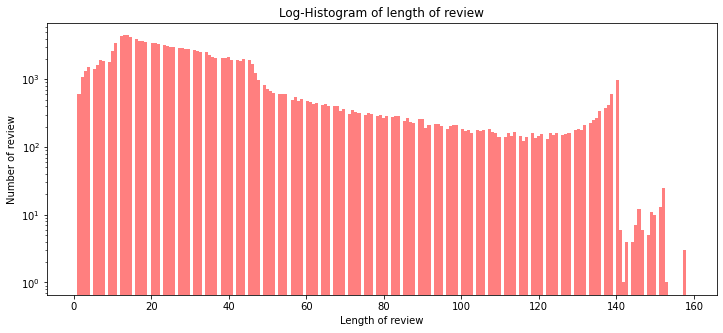

In [3]:
#drawing histogram 전체 데이터에 대해 길이에 대한 히스토그램을 그린다.
plt.figure(figsize=(12, 5))
plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonpositive='clip')
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')
plt.show()